# Analysis of the Hospital ward dynamic contacts

[Data](https://networks.skewed.de/net/sp_hospital)

### Imports and loading the data

In [2]:
import pandas as pd
import networkx as nx
import matplotlib
# %matplotlib notebook
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import numpy as np
from collections import Counter
import scipy

#import graph_tool
#from graph_tool import draw
#from graph_tool import inference

In [3]:
names_nodes = ["index", "id", "status", "_pos"]
nodes = pd.read_csv("./data/nodes.csv", delimiter=",", index_col=0, skiprows=1, names=names_nodes)

nodes.drop("id", axis=1, inplace=True)
nodes.drop("_pos", axis=1, inplace=True)

nodes

,status
index,
0,ADM
1,NUR
2,NUR
3,NUR
4,NUR
...,...
70,ADM
71,PAT
72,PAT


In [4]:
names_edges = ["source", "target", "time"]
edges = pd.read_csv("./data/edges.csv", delimiter=",", index_col=[0, 1], skiprows=1, names=names_edges)
start_tsp = int(pd.Timestamp(year=2010, month=12, day=6, hour=13).value / 10**9)
edges["timestamp"] = pd.to_datetime((start_tsp + edges['time']), unit='s')

edges

time           timestamp
source target                            
0      19        3980 2010-12-06 14:06:20
       16        4080 2010-12-06 14:08:00
       5         4280 2010-12-06 14:11:20
       5         4360 2010-12-06 14:12:40
       5         4380 2010-12-06 14:13:00
...               ...                 ...
69     74      336900 2010-12-10 10:35:00
       74      336980 2010-12-10 10:36:20
       72      341700 2010-12-10 11:55:00
       72      341800 2010-12-10 11:56:40
       72      341840 2010-12-10 11:57:20

[32424 rows x 2 columns]

In [5]:
edges_status = edges.reset_index() \
	.merge(nodes, left_on="source", right_index=True) \
	.merge(nodes, left_on="target", right_index=True) \
	.rename(columns={"status_x": "source_status", "status_y": "target_status"})

edges_status

,source,target,time,timestamp,source_status,target_status
0,0,19,3980,2010-12-06 14:06:20,ADM,NUR
52,0,19,71340,2010-12-07 08:49:00,ADM,NUR
530,0,19,156420,2010-12-08 08:27:00,ADM,NUR
531,0,19,156440,2010-12-08 08:27:20,ADM,NUR
532,0,19,156460,2010-12-08 08:27:40,ADM,NUR
...,...,...,...,...,...,...
31878,58,65,223440,2010-12-09 03:04:00,PAT,NUR
31879,58,65,232900,2010-12-09 05:41:40,PAT,NUR
31880,58,65,232920,2010-12-09 05:42:00,PAT,NUR
31881,58,65,233080,2010-12-09 05:44:40,PAT,NUR


### Number of interactions
First we want to find out if number of votes are distributed evenly across the editors.

In [6]:
count_interactions = edges.reset_index().groupby("source")["target"].count().sort_values(ascending=False)
count_interactions.head()

source
6     3757
14    2035
36    1918
10    1799
4     1673
Name: target, dtype: int64

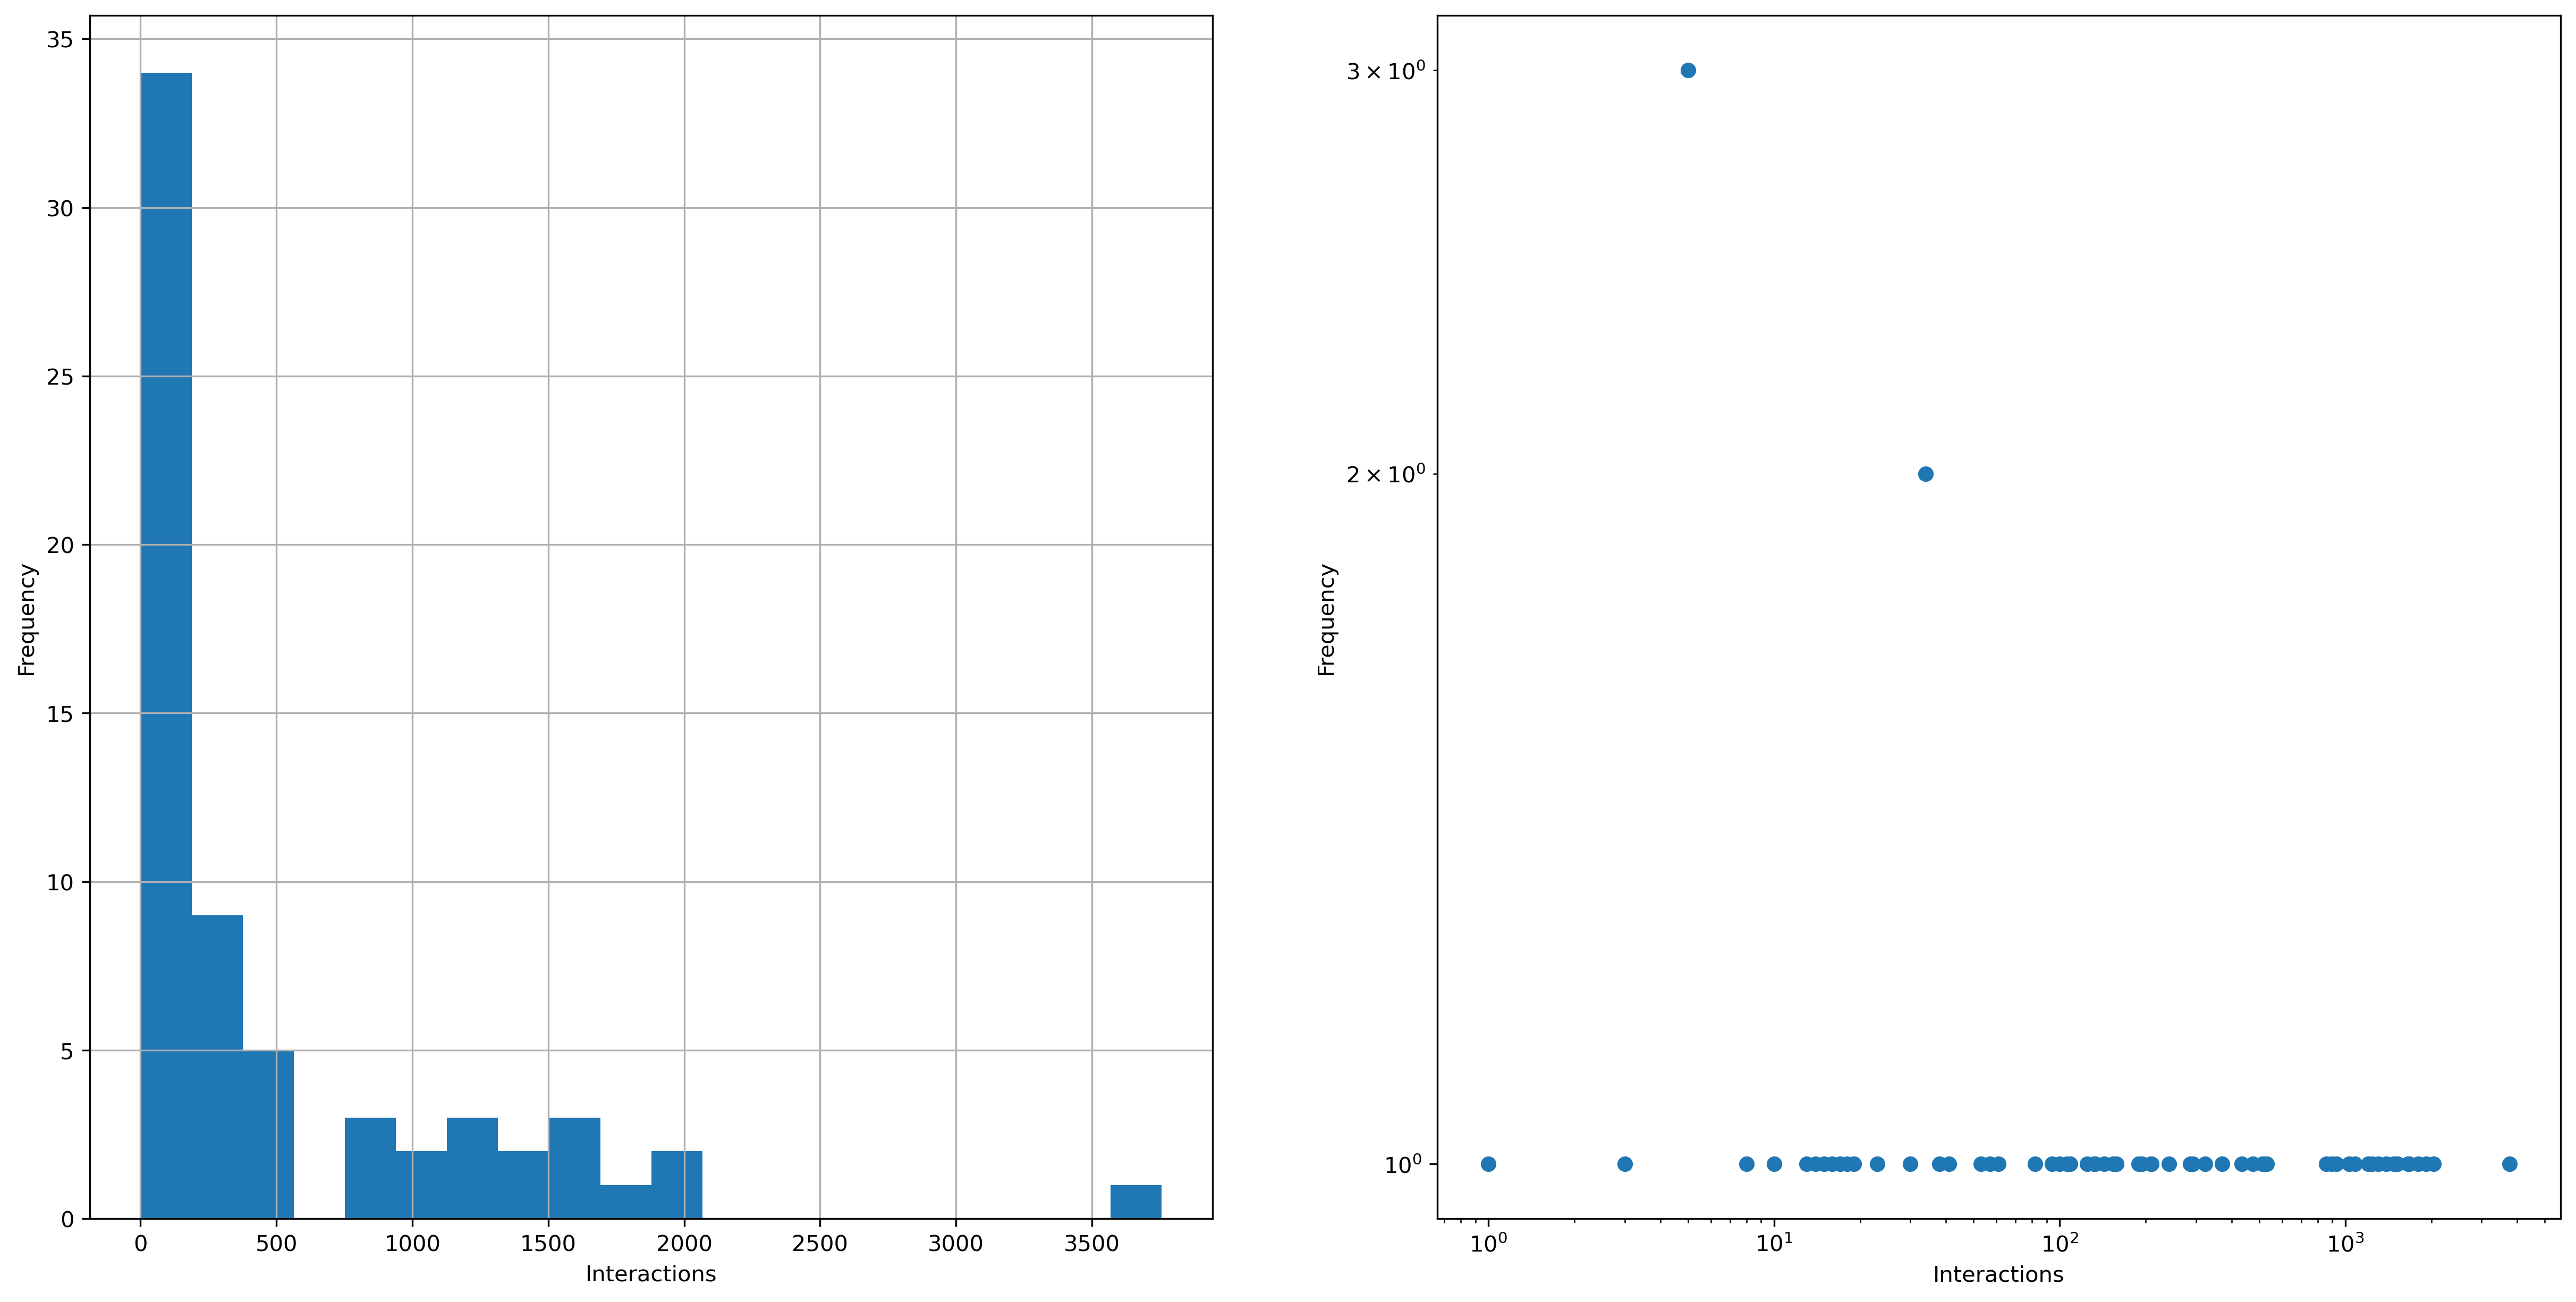

In [33]:
def plot_interactions(df):
	fig = plt.figure(figsize=(20, 10), dpi=300)
	(ax1, ax2) = fig.subplots(1,2)

	df.hist(bins=20, ax=ax1)
	ax1.set_xlabel("Interactions")
	ax1.set_ylabel("Frequency")

	votes_cntr = Counter(df)
	votes_xy = dict(votes_cntr).items()
	x, y = zip(*votes_xy)
	ax2.scatter(x, y)
	ax2.set_xlabel("Interactions")
	ax2.set_ylabel("Frequency")
	ax2.set_xscale("log")
	ax2.set_yscale("log")

	plt.show()

plot_interactions(count_interactions)

Now we want to check for unique interactions

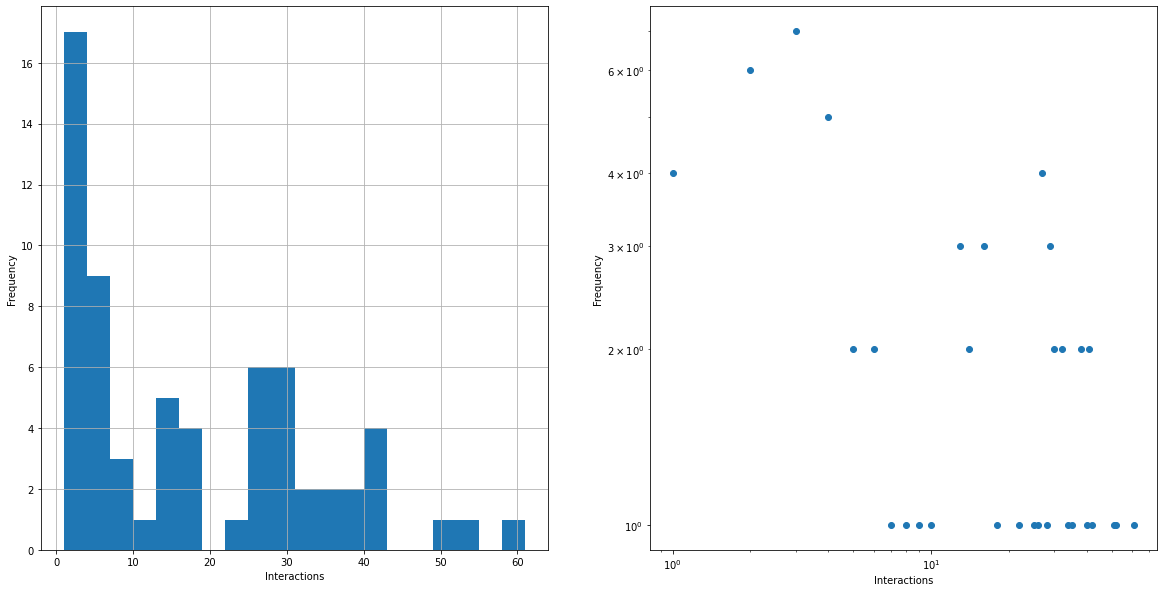

In [8]:
count_unique_interactions = edges.reset_index()[["source", "target"]].drop_duplicates().groupby("source")["target"].count().sort_values(ascending=False)
plot_interactions(count_unique_interactions)

## Analyzing the network
### Build the network

In [9]:
## Create undirected network
G = nx.Graph()
for idx, node in nodes.iterrows():
    G.add_node(idx, group=node["status"])

for idx, edge in edges.iterrows():
    G.add_edge(idx[0], idx[1], time=edge["time"], timestamp=edge["timestamp"])

### Draw the network

In [10]:
# Classes of Hospital People
classes = nodes['status'].unique()
class_to_int = {ci: matplotlib.pyplot.get_cmap("Set1").colors[i] for i, ci in enumerate(classes)}

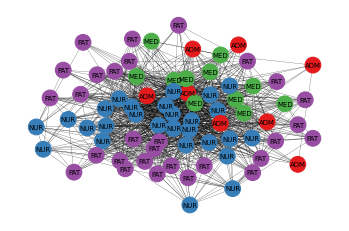

In [11]:
## Compute a layout
default_pos = nx.kamada_kawai_layout(G, scale=1)
default_node_labels = {ni: G.nodes[ni]["group"] for ni in G.nodes}

def plot_graph(graph, ax, node_size=250, node_labels=default_node_labels, pos=default_pos):
	## Fix a node ordering
	nodelist = graph.nodes
	## Convert classes labels to numbers for plotting
	colors = [class_to_int[graph.nodes[ni]["group"]] for ni in nodelist]
	nx.draw_networkx(graph,
					 pos=pos,
					 node_size=node_size,
					 font_size=7,
					 width=0.2,  ## Edge width
					 nodelist=nodelist,
					 node_color=colors,
					 with_labels=True,
					 labels=node_labels,
					 ## Label each node (student) with the class she attends
					 font_color="k",
					 ax=ax,
					 )
	ax.set_axis_off()

fig, ax1 = plt.subplots()
plot_graph(G, ax1)
plt.show()

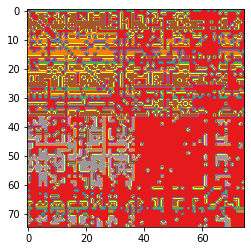

In [12]:
nodes_sorted = sorted([(x, y["group"]) for x, y in G.nodes(data=True)], key=lambda x:x[1])
Adir = nx.to_numpy_array(G)
#Adir[[x for x,y in nodes_sorted if y=="ADM"],:] *= 1
Adir[[x for x,y in nodes_sorted if y=="MED"],:] *= 2
Adir[[x for x,y in nodes_sorted if y=="NUR"],:] *= 3
Adir[[x for x,y in nodes_sorted if y=="PAT"],:] *= 4
plt.imshow(Adir, cmap="Set1")
plt.show()

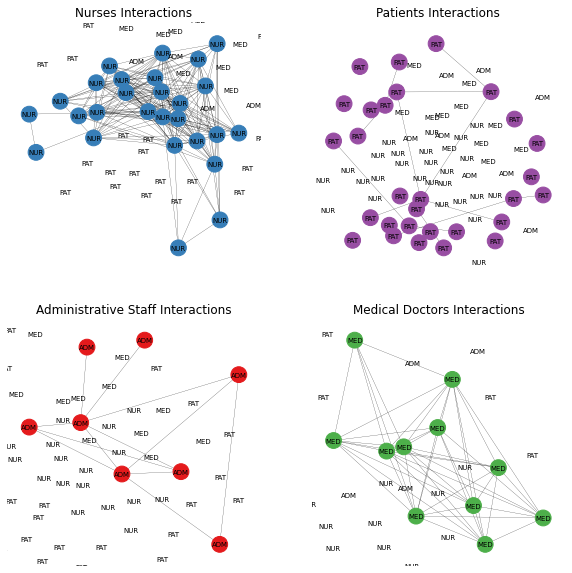

In [13]:
def get_subgraph(group):
	group_nodes = [x for x,y in G.nodes(data=True) if y["group"] == group]
	return G.subgraph(group_nodes)

G_nurse = get_subgraph("NUR")
G_patient = get_subgraph("PAT")
G_administrative = get_subgraph("ADM")
G_doctor = get_subgraph("MED")

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
plot_graph(G_nurse, ax1)
ax1.set_title("Nurses Interactions")
plot_graph(G_patient, ax2)
ax2.set_title("Patients Interactions")
plot_graph(G_administrative, ax3)
ax3.set_title("Administrative Staff Interactions")
plot_graph(G_doctor, ax4)
ax4.set_title("Medical Doctors Interactions")
plt.show()

## Average degree and density

In [14]:
E = G.number_of_edges()
N = G.order()
print("Average degree=", 2 * E / N)

Average degree= 30.373333333333335


In [15]:
dens = E/(0.5*N*(N-1))
"Density", dens, nx.density(G)

('Density', 0.4104504504504505, 0.4104504504504505)

## Node properties

### Degree centrality

In [16]:
## Compute degree of the nodes
degree_dct = G.degree()
## Save it as node attribute in the graph object
nx.set_node_attributes(G, dict(degree_dct), name="degree")

In [17]:
G.nodes[0], G.nodes[10], G.nodes[40], G.nodes[2]

({'group': 'ADM', 'degree': 61},
 {'group': 'MED', 'degree': 50},
 {'group': 'PAT', 'degree': 9},
 {'group': 'NUR', 'degree': 27})

In [18]:
nodes["degree"] = nodes.index.map(dict(degree_dct))
nodes.head()

,status,degree
index,,
0,ADM,61
1,NUR,28
2,NUR,27
3,NUR,34
4,NUR,55


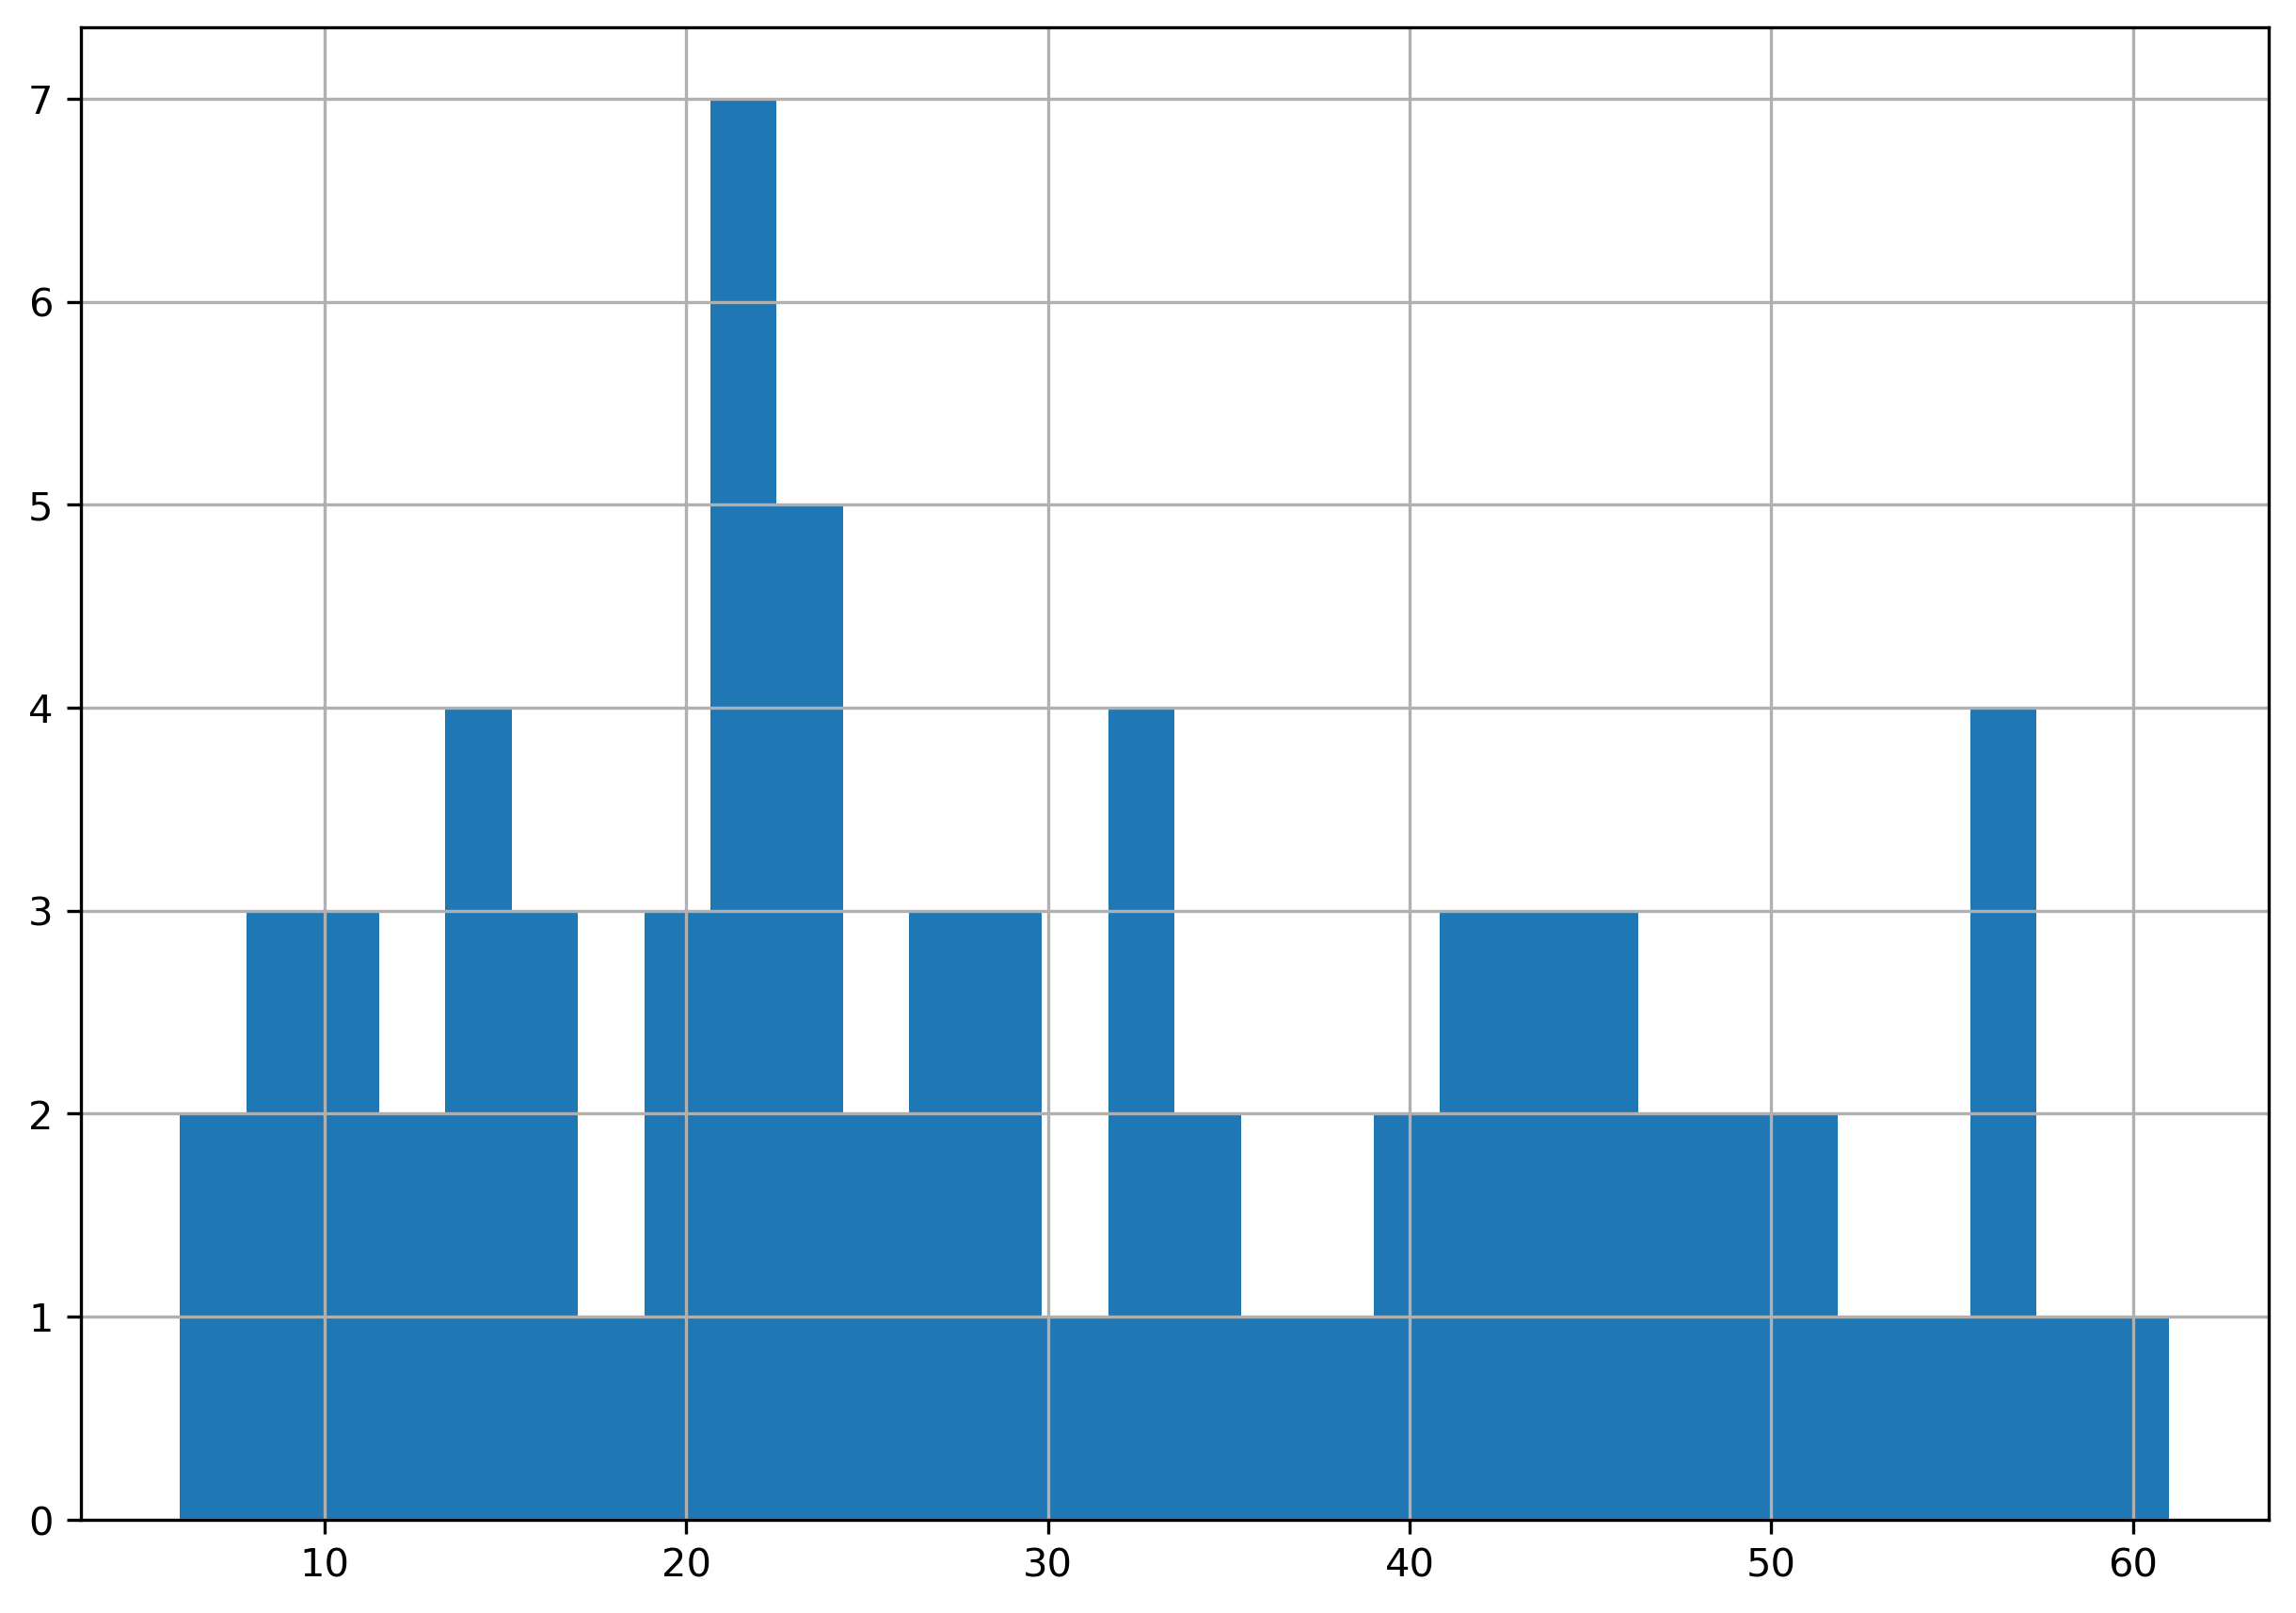

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 7), dpi=300)
nodes["degree"].hist(bins=30)
plt.show()

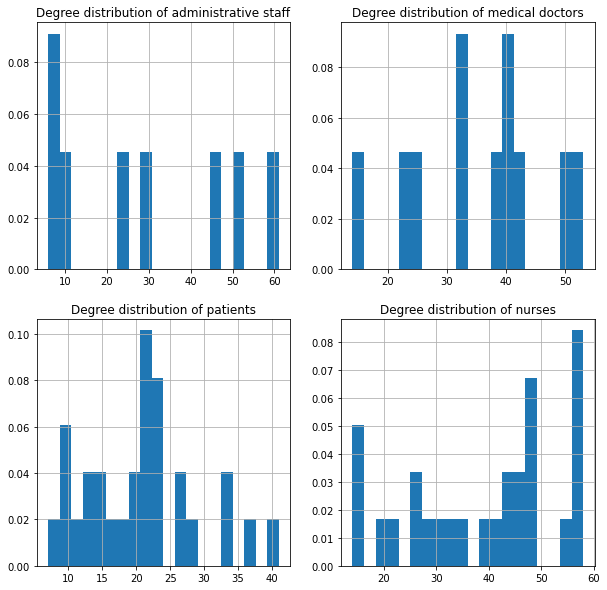

In [20]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))

nodes[nodes["status"] == "ADM"]["degree"].hist(bins=20,density=True, ax=ax1)
ax1.set_title("Degree distribution of administrative staff")
nodes[nodes["status"] == "MED"]["degree"].hist(bins=20,density=True, ax=ax2)
ax2.set_title("Degree distribution of medical doctors")
nodes[nodes["status"] == "PAT"]["degree"].hist(bins=20,density=True, ax=ax3)
ax3.set_title("Degree distribution of patients")
nodes[nodes["status"] == "NUR"]["degree"].hist(bins=20,density=True, ax=ax4)
ax4.set_title("Degree distribution of nurses")

plt.show()

### Draw network scaling node size with degree

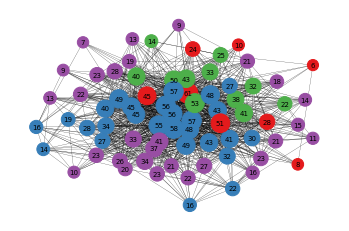

In [21]:
def rescale(x, xmin, xmax, a, b):
	s = (b - a) / (xmax - xmin)
	return (x - xmin) * s + a

custom_node_size = [rescale(nodes.degree.loc[i], 1, nodes["degree"].max(), 100, 400) for i in G.nodes]
degree_node_labels = {ni: str(nodes.degree.loc[ni]) for ni in G.nodes}

_, ( ax1) = plt.subplots(1,1)
plot_graph(G, ax1, custom_node_size, node_labels=degree_node_labels)
plt.show()

### Eigenvector centrality

In [22]:
## Careful with the weight parameter!
eigen_dct = nx.eigenvector_centrality(G, max_iter=1000)

nx.set_node_attributes(G, eigen_dct, name="eigenvector")

nodes['eigenvector'] = nodes.index.map(eigen_dct)
nodes.sort_values("eigenvector", ascending=False).head(10)

,status,degree,eigenvector
index,,,
0,ADM,61,0.190224
16,NUR,57,0.182440
28,NUR,56,0.181339
6,NUR,57,0.180875
36,NUR,56,0.180180
22,NUR,58,0.180152
4,NUR,55,0.177024
14,MED,53,0.174845
10,MED,50,0.168129


### PageRank centrality

In [23]:
## Careful with the weight parameter!
pr_dct = nx.pagerank(G, max_iter=1000)
nx.set_node_attributes(G, pr_dct, name="pagerank")
nodes['pagerank'] = nodes.index.map(pr_dct)
nodes.sort_values("pagerank", ascending=False).head(10)

,status,degree,eigenvector,pagerank
index,,,,
0,ADM,61,0.190224,0.025364
22,NUR,58,0.180152,0.024114
16,NUR,57,0.182440,0.023716
6,NUR,57,0.180875,0.023630
36,NUR,56,0.180180,0.023194
28,NUR,56,0.181339,0.023168
4,NUR,55,0.177024,0.022824
14,MED,53,0.174845,0.021901
68,ADM,51,0.167057,0.021351


### Betweenness centrality

In [24]:
## Careful with the weight parameter!
betwn_dct = nx.betweenness_centrality(G, weight="interactions_inv")
nx.set_node_attributes(G, betwn_dct, name="betweenness")
nodes['betweenness'] = nodes.index.map(betwn_dct)
nodes.sort_values("betweenness", ascending=False).head(10)

,status,degree,eigenvector,pagerank,betweenness
index,,,,,
0,ADM,61,0.190224,0.025364,0.040408
22,NUR,58,0.180152,0.024114,0.035156
16,NUR,57,0.182440,0.023716,0.031266
6,NUR,57,0.180875,0.023630,0.028689
4,NUR,55,0.177024,0.022824,0.027835
36,NUR,56,0.180180,0.023194,0.026828
28,NUR,56,0.181339,0.023168,0.026450
68,ADM,51,0.167057,0.021351,0.022657
20,NUR,48,0.152197,0.020284,0.022165


### Closeness centrality

In [25]:
## Careful with the weight parameter!
close_dct = nx.closeness_centrality(G, distance="interactions_inv")
nx.set_node_attributes(G, close_dct, name="closeness")
nodes['closeness'] = nodes.index.map(close_dct)
nodes.sort_values("closeness", ascending=False).head(10)

,status,degree,eigenvector,pagerank,betweenness,closeness
index,,,,,,
0,ADM,61,0.190224,0.025364,0.040408,0.850575
22,NUR,58,0.180152,0.024114,0.035156,0.822222
6,NUR,57,0.180875,0.023630,0.028689,0.813187
16,NUR,57,0.182440,0.023716,0.031266,0.813187
36,NUR,56,0.180180,0.023194,0.026828,0.804348
28,NUR,56,0.181339,0.023168,0.026450,0.804348
4,NUR,55,0.177024,0.022824,0.027835,0.795699
14,MED,53,0.174845,0.021901,0.021652,0.778947
68,ADM,51,0.167057,0.021351,0.022657,0.762887


### Clustering

In [26]:
## Clustering
clust_dct = nx.clustering(G)
nx.set_node_attributes(G, clust_dct, name="clustering")
nodes['clustering'] = nodes.index.map(clust_dct)
nodes.sort_values("clustering", ascending=False).head(10)

,status,degree,eigenvector,pagerank,betweenness,closeness,clustering
index,,,,,,,
70,ADM,10,0.041794,0.005580,0.000037,0.536232,0.955556
49,PAT,13,0.055859,0.006636,0.000078,0.544118,0.923077
47,PAT,9,0.035350,0.005262,0.000142,0.513889,0.833333
71,PAT,18,0.074335,0.008489,0.000784,0.569231,0.823529
64,PAT,14,0.056009,0.007059,0.000431,0.544118,0.802198
13,MED,14,0.055022,0.007060,0.000310,0.552239,0.802198
39,PAT,19,0.075154,0.008865,0.000746,0.573643,0.795322
27,ADM,24,0.092536,0.010729,0.001335,0.596774,0.782609
2,NUR,27,0.103040,0.011802,0.001908,0.611570,0.760684


## Correlation between different node properties

In [27]:
plt.ioff()

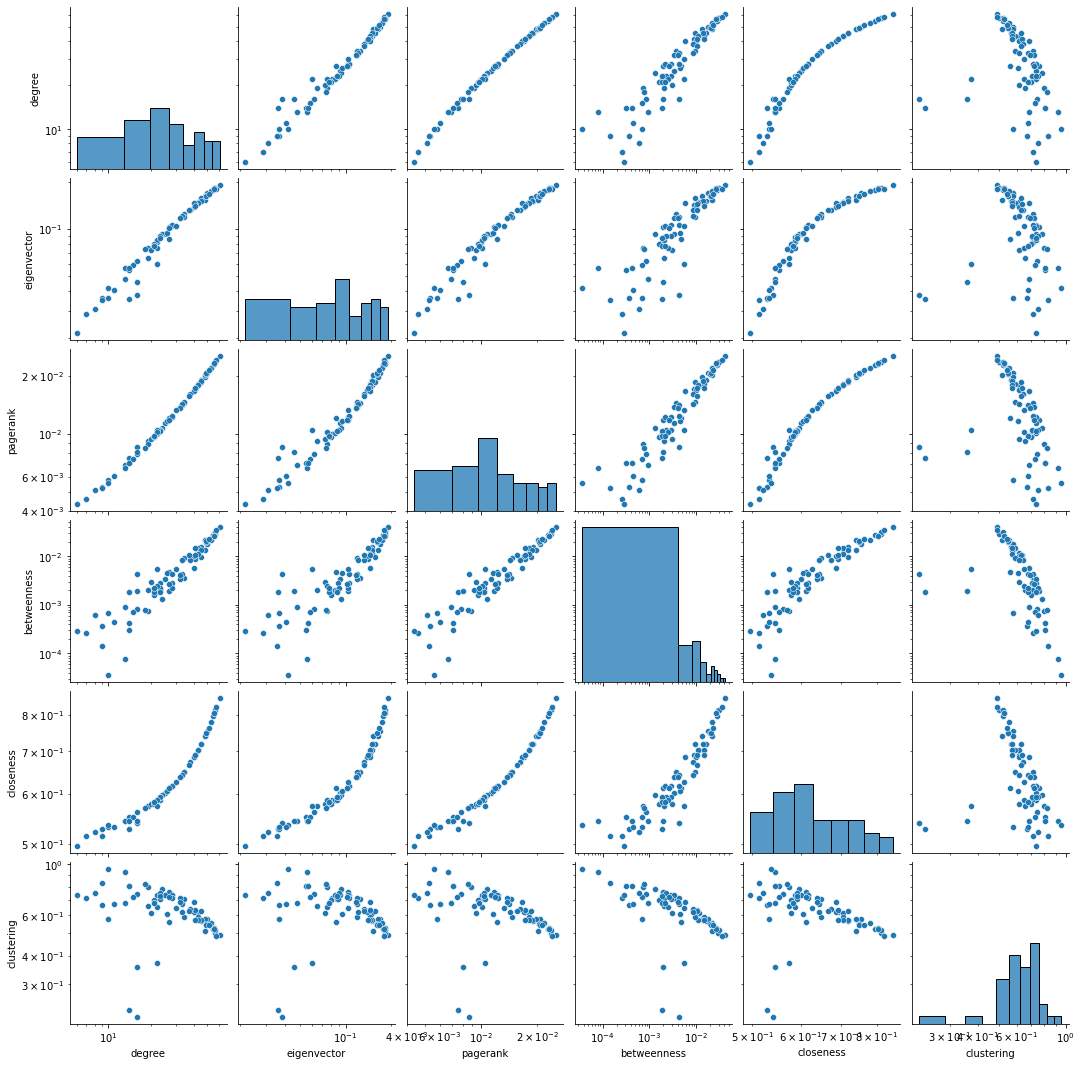

In [28]:
## Pairplot
pg = sns.pairplot(nodes[["degree", "eigenvector", "pagerank", "betweenness", "closeness", "clustering"]])
pg.set(xscale="log",yscale="log")
plt.show()

In [29]:
plt.ion()

# Groups of nodes (communities)
### Convert NetworkX to graph-tool

In [30]:
## Networkx to graph-tool through adjacency matrix
nodelist = list(G.nodes)

A = nx.to_numpy_array(G, nodelist=nodelist)
## Since the network is undirected, convert full matrix to upper triangular
Atu = np.triu(A)

## Extract non-zero indices (the list of links)
Anz = np.nonzero(Atu)

In [31]:
## Build the network as per https://graph-tool.skewed.de/static/doc/quickstart.html (search for undirected graphs)
ug = graph_tool.Graph(
    np.array([Anz[0], Anz[1]]).T, ## List of edges with their weights
    directed=False)

ug.get_edges()

NameError: name 'graph_tool' is not defined

### Find communities by fitting Assortative Schocastic Blockmodel with graph-tool

In [ ]:
## Unweighted assortative
state_uw_ass = inference.minimize_blockmodel_dl(ug, state=inference.PPBlockState)

## Partition quality metric ("goodness of fit")- the lower the better
state_uw_ass.entropy()

In [ ]:
## Refine fit
for _ in range(100):
    state_uw_ass.multiflip_mcmc_sweep(beta=np.inf, niter=10)

state_uw_ass.entropy()

## Store result in our networkx graph
for i, n in enumerate(G.nodes):
    r = state_uw_ass.get_blocks()[i]
    G.nodes[n]["assort_comm"] = r

## Calculate node positions to plot result
new_pos = draw.sfdp_layout(ug)

## Plot result
state_uw_ass.draw(pos=new_pos, output="img/thiers_uw_ass.png",output_size=(4096,4096))

### Hierarchical Schocastic Blockmodel (unweighted)

In [ ]:
state_hierachy = inference.minimize_nested_blockmodel_dl(ug)
state_hierachy.entropy()

for i in range(100):
    state_hierachy.multiflip_mcmc_sweep(beta=np.inf, niter=10)

state_hierachy.entropy()

## Plot result
state_hierachy.draw(pos=new_pos, output="img/Thiers_uw_hierarchical.png",output_size=(4048,4048))

## Layers and blocks per layer
state_hierachy.print_summary()